In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.stats import poisson
from statsmodels.distributions.empirical_distribution import ECDF

### Barabasi-Albert Model
**Definition**: starting with a complete graph of $m_0$ nodes, at each time step $t = 1,...,N-m_0$ a new node $j = t+m_0$ is added.

It forms $m\leq m_0$ undirected edges with existing nodes with a probability proportional to their degree $\pi_{j,i} = \frac{k_i}{\sum_{l \in V_{t-1}}} k_l$.

Result is an undirected graph of $N$ nodes and $K = \frac{m_0(m_1-1)}{2} + m(N-m_0)$ edges.

In [14]:
m0 = 5 #initial number of nodes
m = 5 #5 edges added each time (preferential attachment)
N = 100
G = nx.barabasi_albert_graph(N, m) #The initialization is a graph with with m nodes and no edges.

In [15]:
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

Number of nodes: 100
Number of edges: 475
Average degre: 9.5


/home/emma/.local/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


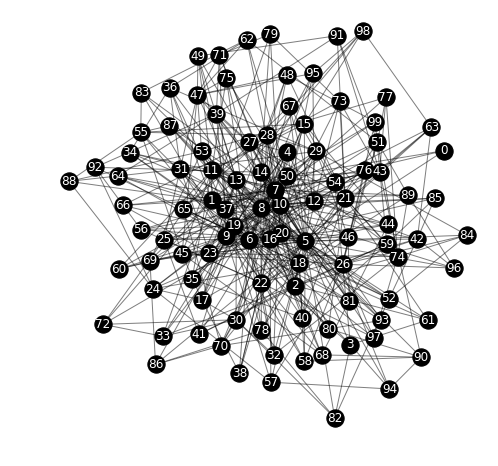

In [16]:
pos = nx.fruchterman_reingold_layout(G);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G, pos, alpha=0.500);
nx.draw_networkx_labels(G, pos, font_color="white");
plt.show();

In [17]:
def degree_distribution(GER):
    vk = dict(GER.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

In [18]:
Count_degree = list(dict(G.degree()).values())

In [19]:
ks, Pk = degree_distribution(G)

**Degree Distribution for a single realisation** - Notice the probability of a lot of the degrees $p(k)$ are 0. For this reason we plot the tail of the degree distribution (1-CDF).

To do this we can get "exact" cdf with `np.cumsum` (not very smooth) or review `Support_Class_2.ipynb` where we calculated a histogram with the data Count_degree to get bins/approximations.

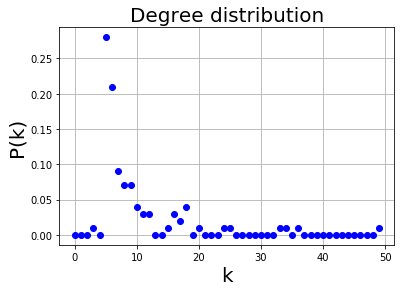

In [20]:
plt.figure()
plt.plot(ks,Pk,'bo', label='Data')
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Degree distribution", fontsize=20)
plt.grid(True)

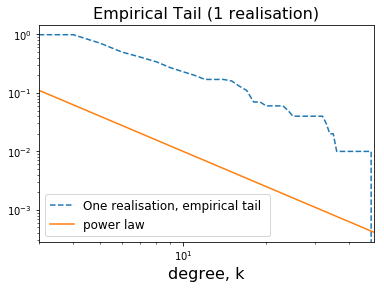

In [21]:
plt.figure()
cdf = np.cumsum(Pk)
x = np.linspace(np.min(Count_degree),np.max(Count_degree),10000)
plt.plot(range(len(cdf)), np.ones(len(cdf))-cdf, '--', label ='One realisation, empirical tail ')
plt.plot(x, x**(-2), label = 'power law')
plt.xlabel('degree, k', fontsize = 16)
plt.title('Empirical Tail (1 realisation)', fontsize = 16)
plt.xlim([np.min(Count_degree),np.max(Count_degree)])
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 12)

In [22]:
realisations = 20
m = 5
N =1000
degrees = []
for r in range(realisations):
    G= nx.barabasi_albert_graph(N,m)
    Count_degree = list(dict(G.degree()).values())
    degrees.append(Count_degree)
degrees = np.array(degrees)
degrees = degrees.flatten()

In [25]:
ecdf_deg = ECDF(degrees)

(1e-06, 1)

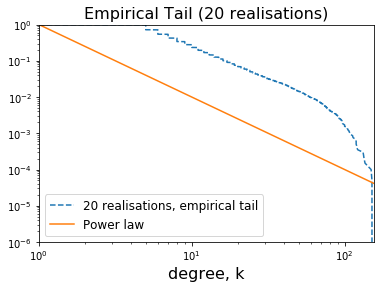

In [26]:
plt.figure()
# bins, deg = one_cdf(degrees)
plt.plot(ecdf_deg.x, np.ones(len(ecdf_deg.y))-ecdf_deg.y, '--', label = '20 realisations, empirical tail')
Xx = np.linspace(min(degrees), max(degrees), 1000)
plt.plot(Xx, Xx**(-2), label = 'Power law')
plt.title('Empirical Tail (20 realisations)', fontsize = 16)

plt.legend(fontsize =12)
plt.xlabel('degree, k', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.xlim([np.min(degrees),np.max(degrees)])
plt.ylim([1e-6, 1])

**Uncorrelated or (dis-)assortative?**

Expected degree of nearest neighbour, given node has node $k$:

$$k_{nn}(k) = \mathbb{E}\left[ \frac{\sum_{i \in V} k_{nn, i} \delta_{k_i,k}}{\sum_{i \in V} \delta_{k_i, k} } \right], \ \text{where} \ k_{nn,i} = \frac{1}{k_i} \sum_{j \in V} a_{ij}k_j$$

To find $k_{nn,i}$ we can use `nx.average_neighbor_degree(G)`

In [27]:
m = 10
N = 1000
G = nx.barabasi_albert_graph(N, m) 

In [28]:
def k_nn(G,kmax):
    knn = np.zeros(kmax) #be careful if you get zeros! There are undefined ( can't divide through by zero)
    Degrees = list(dict(G.degree()).values())
    Degrees = np.array(Degrees)
    knn_i = np.array(list(nx.average_neighbor_degree(G).values()))
    for k in range(kmax):
        delta_ki_k = np.equal(Degrees, k).astype(int)
        numerator = np.sum(delta_ki_k*knn_i)
        denominator = np.sum(delta_ki_k)
        if denominator !=0:
            knn[k] = numerator/denominator
    return knn

In [29]:
realisations = 20
kmax = 200
M = np.zeros((kmax, realisations))
for i in range(realisations):
    G = nx.barabasi_albert_graph(N,m)
    knn_final = k_nn(G, kmax)
    for k in range(len(knn_final)):
        if knn_final[k] == 0:
            knn_final[k] = None #undefined values
    M[:,i] = knn_final

In [30]:
Average = np.mean(M, axis = 1)

Text(0, 0.5, '$k_{nn}(k)$ ')

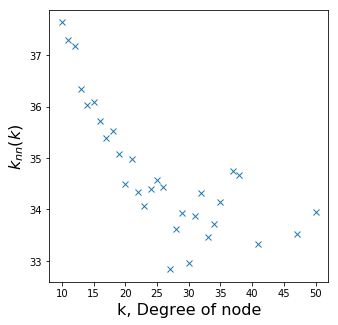

In [31]:
plt.figure(figsize = (5,5))
plt.plot(range(kmax), Average, 'x')
plt.xlabel('k, Degree of node', fontsize = 16)
plt.ylabel(r'$k_{nn}(k)$ ', fontsize = 16)